### Imports

In [1]:
import pandas as pd
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import LabelEncoder

### Read Files

In [3]:
X_fileName = []
y_val = []

In [4]:
for fileName in sorted(glob.iglob('near-infrared/**/train_pose/**/**', recursive=False)):
    X_fileName.append(fileName)
    y_val.append(fileName.split("\\")[-2])

##### Converting to DataFrame for easy handling

In [5]:
myDf = pd.DataFrame()
myDf['fileName'] = X_fileName
myDf['label'] = y_val

In [6]:
myLabelEncoder = LabelEncoder()
myDf['label_val'] = myLabelEncoder.fit_transform(myDf['label'])

### PreProcessing

In [7]:
def preprocessingSingleImage(filepath):
    
    img = cv2.imread(filepath)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    k = cv2.normalize(img1, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    blur = cv2.GaussianBlur(k,(5,5),0)
    ret, thresh1 = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    
    for k in range(2, nb_components):
        if sizes[k] > max_size:
            max_label = k
            max_size = sizes[k]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255

    new_image = img2[stats[max_label][1]:stats[max_label][1]+stats[max_label][3],stats[max_label][0]:stats[max_label][0]+stats[max_label][2]]
    image_for_input = cv2.resize(new_image, (100, 100), interpolation = cv2.INTER_NEAREST)
    
    return image_for_input

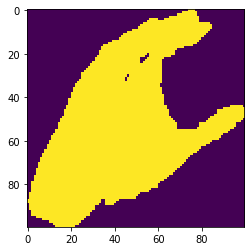

In [8]:
plt.imshow(preprocessingSingleImage(myDf['fileName'][0]))

### Creating our generator

In [9]:
def my_generator(features, batch_size=16):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 100, 100, 1))
    batch_labels = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features[i] = preprocessingSingleImage(features.loc[index[0]]['fileName']).reshape([100, 100, 1])
            batch_labels[i] = features.loc[index[0]]['label_val']
        yield batch_features, batch_labels

### Model Benchmarking

##### Nvidia Model

In [10]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

Using TensorFlow backend.


In [21]:
def MyModel(input_shape):
    
    model = Sequential()

    model.add(Lambda(lambda x: x / 255 - 0.5, input_shape=input_shape))

    model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

In [24]:
myMod = MyModel([100, 100, 1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


In [ ]:
myMod.fit_generator(my_generator(myDf), samples_per_epoch=200, nb_epoch=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=200, epochs=5)`
  """Entry point for launching an IPython kernel.


Epoch 1/5
200/200 [==============================] - 40s 199ms/step - loss: 23.9552 - accuracy: 0.0622
Epoch 2/5
169/200 [========================>.....] - ETA: 4s - loss: 18.0242 - accuracy: 0.0721